In [1]:
import sys
sys.path.append('../..')
import argparse
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from utils.bundlenet_continuous_variant import BunDLeNet, train_model
from utils.functions import preprocess_data, prep_data
from utils.plotting_functions import plot_phase_space


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso

import os
os.chdir('../..')

%reload_ext autoreload
%autoreload 2
os.getcwd()

'/Users/aksheykumar/Desktop/BunDLe-Net'

## Load Data

In [2]:
fish_data_id = '220119_F2_F2_run11' #220119_F2_F2_run11, 220127_F4_F4_run2
path_neuronal_data ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_cells_spike_rate_signals.npy' 
path_behaviour_data1 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_directionality.npy'
path_behaviour_data2 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_vigour.npy'

In [3]:
X = np.load(path_neuronal_data).T
B1 = np.load(path_behaviour_data1)
B2 = np.load(path_behaviour_data2)
B = np.c_[B1, B2]

### Remove NaNs
B = B[~np.isnan(X[:,0])]
X = X[~np.isnan(X[:,0])]
B.shape, X.shape

### Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
B = StandardScaler(with_mean=False).fit_transform(B)
X = StandardScaler(with_mean=False).fit_transform(X)

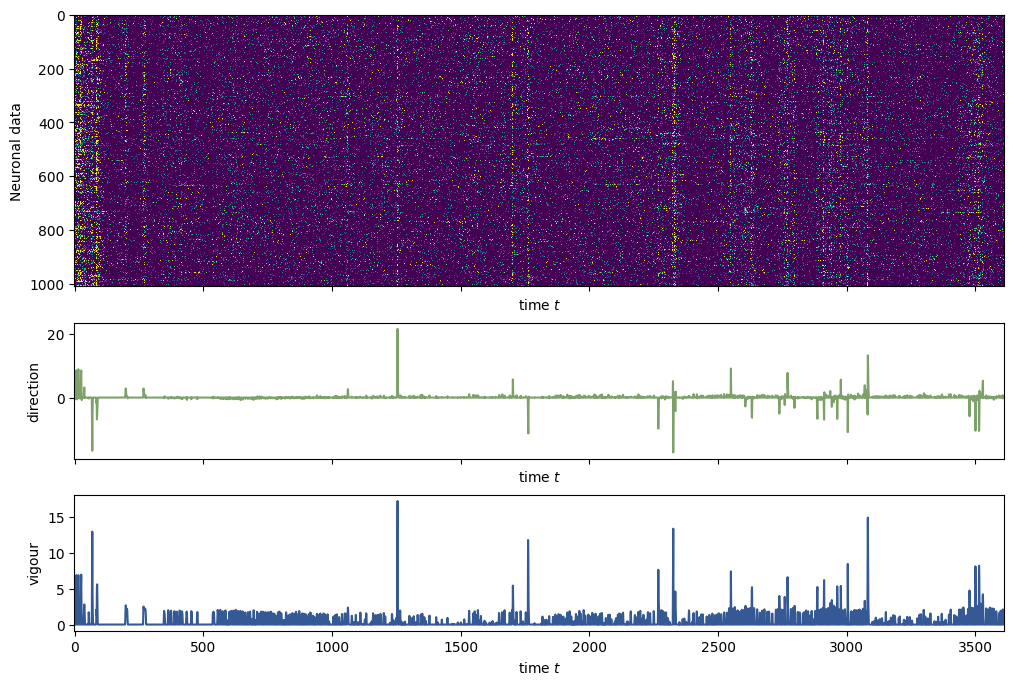

In [ ]:
def plotting_neuronal_behavioural(X,B, state_names=[], **kwargs):
    fig, axs = plt.subplots(3,1,figsize=(12,8),  sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
    im0 = axs[0].imshow(X.T,aspect='auto', interpolation='None', **kwargs)
    # tell the colorbar to tick at integers
    axs[0].set_xlabel("time $t$")
    axs[0].set_ylabel("Neuronal data")
    
    colors = ['#7EA16B', '#345995', '#AF125A']
    ylabels = ['direction', 'vigour']
    for i in range(2):
        # Behaviour 1
        im1 = axs[i+1].plot(B[:,i], c=colors[i])
        axs[i+1].set_xlabel("time $t$")
        axs[i+1].set_ylabel(ylabels[i])
        #axs[i+1].set_yticks([])

    plt.show()
    
plotting_neuronal_behavioural(X,B, vmin=0, vmax=5)

# Cross validation

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
mean_score = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    B_train, B_test = B[train_index], B[test_index]
    
    # Regression
    reg = LinearRegression().fit(X_train, B_train)
    print('test score =',reg.score(X_test, B_test))

    mean_score.append(reg.score(X_test, B_test))
    B_pred = reg.predict(X_test)
    #plot_compare_B_pred(B_test, B_pred)

print('mean score on test set: ', np.mean(mean_score))    

test score = 0.32388086792453585
test score = -2.6833919401512913
test score = -1.221829149398225
test score = 0.5141007090374397
test score = 0.5508745114574047
test score = -1.4865679149221322
test score = 0.2908360537627441
test score = 0.5528720654481603
test score = 0.4658861240521435
test score = 0.5609963156094252
mean score on test set:  -0.2132342357179796


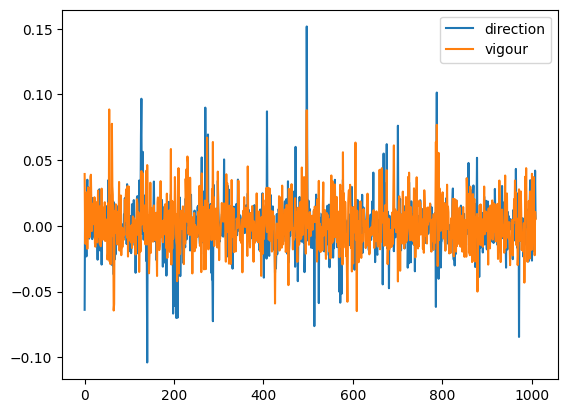

In [6]:
plt.plot(reg.coef_[0], label='direction')
plt.plot(reg.coef_[1], label='vigour')
plt.legend()
np.savetxt('coeff_linear_regression',reg.coef_)

## Lasso regression

In [ ]:
kf = KFold(n_splits=10)
mean_score = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    B_train, B_test = B[train_index], B[test_index]
    # Regression
    reg = Lasso(alpha=0.1).fit(X_train, B_train[:,:])
    print('train score=',reg.score(X_train, B_train[:,:]))
    print('test score =',reg.score(X_test, B_test[:,:]))

    mean_score.append(reg.score(X_test, B_test[:,:]))
    B_pred = reg.predict(X_test)
    #plot_compare_B_pred(B_test, B_pred)

print('mean score on test set: ', np.mean(mean_score), 'pm', np.std(mean_score))    

In [ ]:
plt.plot(reg.coef_[0], label='direction')
plt.plot(reg.coef_[1], label='vigour')
plt.legend()
np.savetxt('coeff_lasso_reg_alpha_1E-1',reg.coef_)

# Taking many time steps into account


In [ ]:
X_, B_ = prep_data(X, B, win = 10)
X_ = X_[:,1,:,:].reshape(X_.shape[0], -1)

kf = KFold(n_splits=10)
mean_score = []

for i, (train_index, test_index) in enumerate(kf.split(X_)):
    X_train, X_test = X_[train_index], X_[test_index]
    B_train, B_test = B_[train_index], B_[test_index]
    # Regression
    reg = Lasso(alpha=0.1).fit(X_train, B_train[:,:])
    print('train score=',reg.score(X_train, B_train[:,:]))
    print('test score =',reg.score(X_test, B_test[:,:]))

    mean_score.append(reg.score(X_test, B_test[:,:]))
    B_pred = reg.predict(X_test)
    #plot_compare_B_pred(B_test, B_pred)

print('mean score on test set: ', np.mean(mean_score), 'pm', np.std(mean_score))    

In [ ]:
plt.plot(reg.coef_[0], label='direction')
plt.plot(reg.coef_[1], label='vigour')
plt.legend()
np.savetxt('coeff_lasso_reg_alpha_1E-1_win_10',reg.coef_)

In [ ]:
plt.matshow(reg.coef_[0].reshape(10,-1), aspect='auto', cmap='seismic', vmin=-0.1, vmax=0.1, extent=[0,X.shape[1],0, -10])
plt.figure()
plt.matshow(reg.coef_[1].reshape(10,-1), aspect='auto', cmap='seismic', vmin=-0.1, vmax=0.1, extent=[0,X.shape[1],0, -10])


In [ ]:
np.savetxt('coeffs_lasso_reg_alpha_1E-1_win_10_direction', reg.coef_[0].reshape(10,-1))
np.savetxt('coeffs_lasso_reg_alpha_1E-1_win_10_vigour', reg.coef_[1].reshape(10,-1))


## Statistical testing

fitted model score =  0.5588649072438254
p-value =  0.0


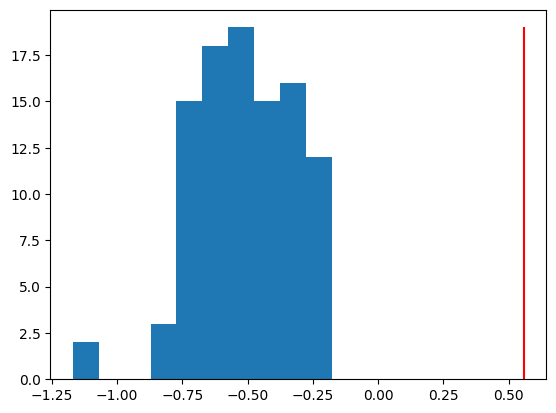

In [68]:
def statistical_test(X_train, X_test, B_train, B_test, model, n_iter=100):
    
    fitted_model = model.fit(X_train, B_train)
    fitted_model_score = fitted_model.score(X_test, B_test)
    
    shuffled_model_scores = []
    for i in range(n_iter):
        randint = np.random.randint(100, B_train.shape[0])
        B_shuffled = np.roll(B_train, randint, axis=0)

        shuffled_model = model.fit(X_train, B_shuffled)
        shuffled_model_score = shuffled_model.score(X_test, B_test)
        shuffled_model_scores.append(shuffled_model_score)

    shuffled_model_scores =  np.array(shuffled_model_scores)
    p_value = np.mean((shuffled_model_scores > fitted_model_score).astype(int))
    
    # Plotting
    hist = plt.hist(shuffled_model_scores)
    plt.vlines(x=fitted_model_score, ymin=0, ymax=hist[0].max(), colors='r')
    print('fitted model score = ', fitted_model_score)
    print('p-value = ', p_value)
    return fitted_model_score, shuffled_model_scores, p_value

fitted_model_score, null_dist, p_value = statistical_test(X_train, X_test, B_train[:,1], B_test[:,1], LinearRegression(), n_iter=100)

fitted model score =  0.5588649072438254
p-value =  0.0


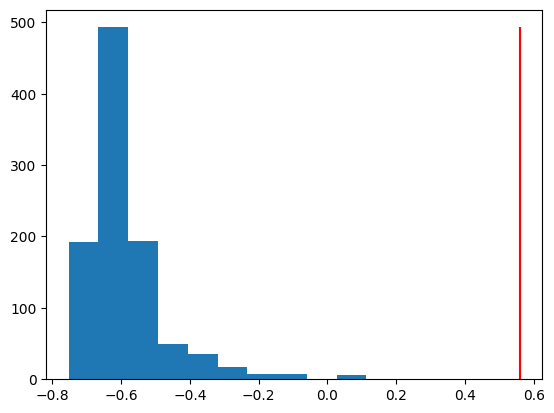

In [69]:
def statistical_test_a_la_moritz(X_train, X_test, B_train, B_test, model, n_iter=100):
    
    fitted_model = model.fit(X_train, B_train)
    fitted_model_score = fitted_model.score(X_test, B_test)
    
    shuffled_model_scores = []
    for i in range(n_iter):
        randint = np.random.randint(100, B_test.shape[0])
        B_test_shuffled = np.roll(B_test, randint, axis=0)

        shuffled_model_score = fitted_model.score(X_test, B_test_shuffled)
        shuffled_model_scores.append(shuffled_model_score)

    shuffled_model_scores =  np.array(shuffled_model_scores)
    p_value = np.mean((shuffled_model_scores >= fitted_model_score).astype(int))
    
    # Plotting
    hist = plt.hist(shuffled_model_scores)
    plt.vlines(x=fitted_model_score, ymin=0, ymax=hist[0].max(), colors='r')
    print('fitted model score = ', fitted_model_score)
    print('p-value = ', p_value)
    return fitted_model_score, shuffled_model_scores, p_value

fitted_model_score, null_dist, p_value = statistical_test_a_la_moritz(X_train, X_test, B_train[:,1], B_test[:,1], LinearRegression(), n_iter=1000)

In [57]:
B_train[].shape

(3252, 2)

fitted model score =  0.6080345441063353
p-value =  0.0


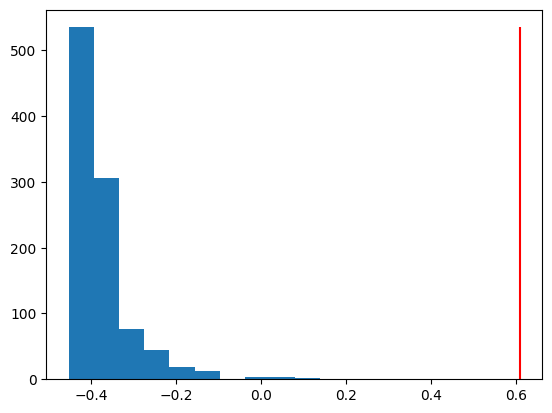

In [26]:
fitted_model_score, null_dist, p_value = statistical_test_a_la_moritz(X_train, X_test, B_train, B_test, Lasso(alpha=0.02), n_iter=1000)


In [27]:
coef -> (n_neurons)
fish_plot(coef, fish_data_id="220119_F2_F2_run11")

NameError: name 'model' is not defined

In [56]:

def fish_plot(coef, fish_data_id,coef_name):
    intensity_values=coef
    cellpos = np.load(fish_data_id_cellpos_file)
    fig = plt.figure(figsize=(15,3))
    plt.title(coef_name)
    x = cellpos[:, 0]
    y = cellpos[:, 1]
    z = cellpos[:, 2]
    plt.scatter(x,-z,c=intensity_values,cmap='bwr',vmax=0.1,vmin=-0.1)
    plt.colorbar()
    fig = plt.figure(figsize=(15,3))
    plt.scatter(x,y,c=intensity_values,cmap='bwr',vmax=0.1,vmin=-0.1)
    plt.gca().invert_yaxis()
    plt.colorbar()

